In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pathlib
from pathlib import Path
os.chdir("/content/drive/My Drive/Classroom/projects/BERT")
!ls -l

total 11928
-rw------- 1 root root  362601 Nov  1 07:23 'Base Model.ipynb'
-rw------- 1 root root   98055 Oct 30 10:23 'Base Model.pdf'
drwx------ 2 root root    4096 Oct 28 08:56  clr
drwx------ 2 root root    4096 Sep 12 15:56  Data
-rw------- 1 root root  886614 Sep 21 17:52  EDA.ipynb
-rw------- 1 root root  634262 Sep 21 17:48  EDA.pdf
drwx------ 2 root root    4096 Oct 28 09:17  fit
-rw------- 1 root root   71427 Nov  1 03:28  model.png
drwx------ 2 root root    4096 Sep 12 15:53  papers
-rw------- 1 root root 5429800 Nov  1 03:50  tdl.hdf5
drwx------ 2 root root    4096 Oct 23 04:35  waste
-rw------- 1 root root 4708376 Oct 31 17:11  yolo.hdf5


In [ ]:
pip install -q tensorflow-text

     |████████████████████████████████| 4.4 MB 5.3 MB/s 


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import xml.etree.ElementTree as et
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
from pathlib import Path
import csv
from tqdm.notebook import tqdm
from wordcloud import WordCloud, STOPWORDS


from sklearn.preprocessing import StandardScaler, LabelBinarizer,OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import scipy
import pickle

import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_text as tf_text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
csvfile = 'Data//data.csv'
sent_data_file = 'Data//sent_data.csv'
label_file = 'Data//label.csv'
vocab_file = 'Data//vocab_tr_w.txt'

In [ ]:
sent_df = pd.read_csv(sent_data_file)

In [ ]:
label = pd.read_csv(label_file)

In [ ]:
data = tf.data.TextLineDataset(sent_data_file)
tr_size = int(sent_df.shape[0]*0.7)
train = data.skip(1).take(tr_size)
test = data.skip(1+tr_size).take(sent_df.shape[0]-(tr_size))

In [ ]:
y_tr = label[:tr_size].values
y_ts = label[tr_size:].values

In [ ]:
len(y_tr),len(y_ts)

(832588, 356824)

In [ ]:
len([1 for _ in train])

832588

In [ ]:
len([1 for _ in test])

356824

https://www.tensorflow.org/text/guide/subwords_tokenizer used to run the following cells

In [ ]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 12000,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

In [ ]:
%%time
vocabulary = bert_vocab.bert_vocab_from_dataset(
    train.batch(10).prefetch(2),
    **bert_vocab_args
)

CPU times: user 9min 3s, sys: 7.54 s, total: 9min 11s
Wall time: 8min 38s


In [ ]:
print(vocabulary[:10])
print(vocabulary[100:110])
print(vocabulary[1000:1010])
print(vocabulary[-10:])

['[PAD]', '[UNK]', '[START]', '[END]', '!', '"', '#', '$', '%', '&']
['as', 'be', 'this', 'cite', 'on', 'can', 'from', 'it', 'an', 'which']
['typical', 'implementation', 'makes', 'notation', 'reported', 'relatively', 'color', 'iii', 'sequences', 'sect']
['##ø', '##μ', '##π', '##†', '##•', '##‰', '##€', '##␣', '##♭', '##♯']


In [ ]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'wb') as f:
    pickle.dump(vocab,f)

write_vocab_file('Data//vocab_tr_wb', vocabulary)

In [ ]:
vocab = []
with open('Data//vocab_tr_wb','rb') as f:
  vocab = pickle.load(f)

In [ ]:
vocab[:10]

['[PAD]', '[UNK]', '[START]', '[END]', '!', '"', '#', '$', '%', '&']

In [ ]:
type(vocab)

list

In [ ]:
tokenizer = tf_text.BertTokenizer('Data//vocab_tr_w.txt', **bert_tokenizer_params)

In [ ]:
train_tok = train.map( lambda x: tokenizer.tokenize(x))
train_tok = train_tok.map( lambda x: x.merge_dims(-2,-1))

In [ ]:
type(train_tok)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [ ]:
ListOfTensors = []
for ele in train_tok:
  #print(ele.numpy()[0])
  ListOfTensors.append(ele.numpy()[0].tolist())
#print(ListOfTensors)

In [ ]:
file1 = open('Data//ListOfTensors', 'wb')
pickle.dump(ListOfTensors, file1)
file1.close()

In [ ]:
#file1 = open('Data//ListOfTensors', 'wb')
#pickle.dump(ListOfTensors, file1)
#file1.close()

ListOfTensors = []
with open('Data//ListOfTensors', 'rb') as f:
  ListOfTensors = pickle.load(f)

In [ ]:
type(ListOfTensors),len(ListOfTensors)

(list, 832588)

In [ ]:
test_tok = test.map( lambda x: tokenizer.tokenize(x))
test_tok = test_tok.map( lambda x: x.merge_dims(-2,-1))

In [ ]:
ListOfTensors_ts = []
for ele in test_tok:
  #print(ele.numpy()[0])
  ListOfTensors_ts.append(ele.numpy()[0].tolist())
#print(ListOfTensors)

In [ ]:
file1 = open('Data//ListOfTensors_ts', 'wb')
pickle.dump(ListOfTensors_ts, file1)
file1.close()

In [ ]:
#file1 = open('Data//ListOfTensors_ts', 'wb')
#pickle.dump(ListOfTensors_ts, file1)
#file1.close()
ListOfTensors_ts = []
with open('Data//ListOfTensors_ts', 'rb') as f:
  ListOfTensors_ts = pickle.load(f)

In [ ]:
type(ListOfTensors),len(ListOfTensors)

(list, 832588)

In [ ]:
type(ListOfTensors_ts),len(ListOfTensors_ts)

(list, 356824)

In [ ]:
# Credits: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
# LSTM for sequence classification in the IMDB dataset
import numpy
# from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)

In [ ]:
from sklearn.model_selection import train_test_split

X_tr, X_ts = ListOfTensors, ListOfTensors_ts

In [ ]:
max_sbe_length = 128
X_tr = sequence.pad_sequences(X_tr, maxlen=max_sbe_length)
X_ts = sequence.pad_sequences(X_ts, maxlen=max_sbe_length)

In [ ]:
# truncate and/or pad input sequences
print(X_tr.shape)
print(X_tr[0])

(832588, 128)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    5   91 4706  108 3078 1003 1577   85  227   94  313  818
  315 6534 6045   88 2218  210   92  372  118 1657   39   86   39   14
   39   96   39  112  100 1235   39   86   39   92   39   86   39   88
   18 1015  232   39   86   39   88   39   86   39   92   39   86   39
   16    5]


In [ ]:
tf.__version__

'2.6.0'

##CNN Based model


In [ ]:
# create the model
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense,Dropout,LSTM,Conv1D,MaxPooling1D,LeakyReLU,Flatten,Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Flatten,Input,Conv2D,MaxPooling2D,Reshape,BatchNormalization
from keras.layers.merge import concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from clr import clr_callback
from tensorflow.python.keras.callbacks import TensorBoard
from time import time


batchSize = 128
sequence_length = max_sbe_length
channels = 1
embedding_vecor_length = 32
num_filters =64

In [ ]:
#def space_to_depth_x2(x):
#    return tf.nn.space_to_depth(x, block_size=8)

In [ ]:
input = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=len(vocab), output_dim=embedding_vecor_length, input_length=sequence_length)(input)
reshape = Reshape((sequence_length,embedding_vecor_length,1))(embedding)
conv_0 = Conv2D(64, kernel_size=(3, embedding_vecor_length), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(32, kernel_size=(3, embedding_vecor_length), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(8, kernel_size=(3, embedding_vecor_length), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPooling2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPooling2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPooling2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(0.2)(flatten)
output = Dense(units=1, activation='sigmoid')(dropout)

# this creates a model that includes
model = Model(inputs=input, outputs=output)


print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 128, 32)      377600      input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 128, 32, 1)   0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 126, 1, 64)   6208        reshape[0][0]                    
______________________________________________________________________________________________

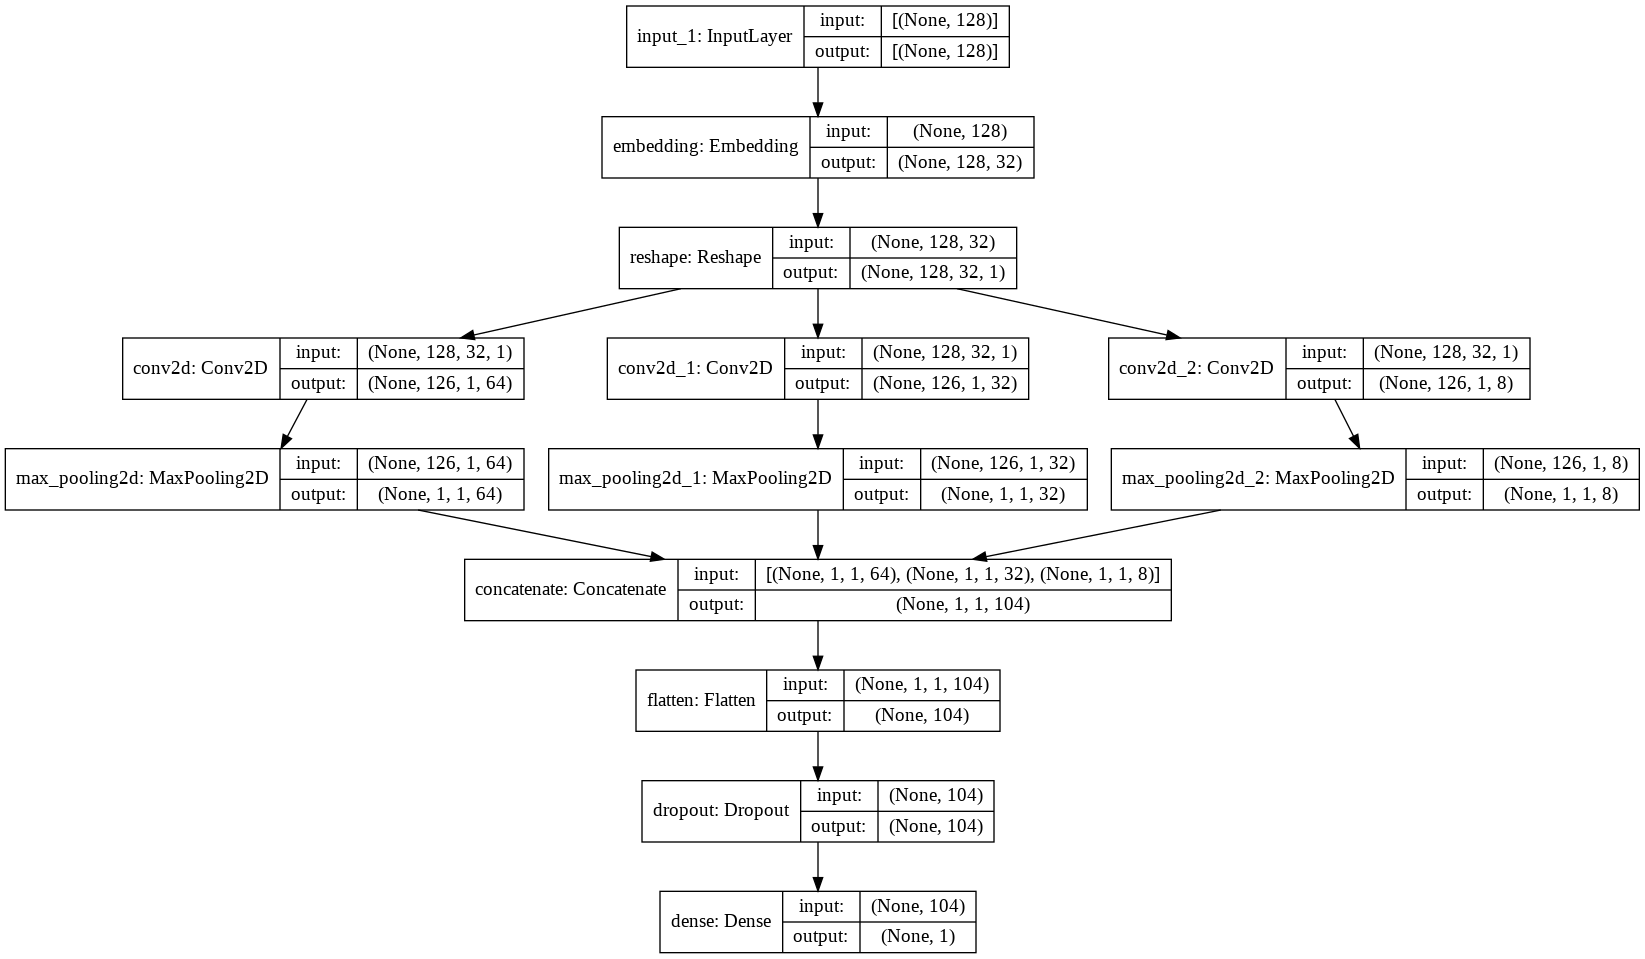

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
filepath="yolo.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,save_best_only=True, mode='min')


callbacks_list = [checkpoint]
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])


In [ ]:
history = model.fit(X_tr, y_tr, validation_split = 0.3, epochs=10, verbose=1,batch_size=batchSize, callbacks = callbacks_list)

Epoch 1/10
4554/4554 [==============================] - 350s 77ms/step - loss: 0.5955 - accuracy: 0.6769 - val_loss: 0.6315 - val_accuracy: 0.6560

Epoch 00001: val_loss improved from inf to 0.63146, saving model to yolo.hdf5
Epoch 2/10
4554/4554 [==============================] - 350s 77ms/step - loss: 0.5586 - accuracy: 0.7103 - val_loss: 0.6333 - val_accuracy: 0.6569

Epoch 00002: val_loss did not improve from 0.63146
Epoch 3/10
4554/4554 [==============================] - 350s 77ms/step - loss: 0.5352 - accuracy: 0.7294 - val_loss: 0.6447 - val_accuracy: 0.6553

Epoch 00003: val_loss did not improve from 0.63146
Epoch 4/10
4554/4554 [==============================] - 350s 77ms/step - loss: 0.5148 - accuracy: 0.7453 - val_loss: 0.6559 - val_accuracy: 0.6566

Epoch 00004: val_loss did not improve from 0.63146
Epoch 5/10
4554/4554 [==============================] - 369s 81ms/step - loss: 0.4960 - accuracy: 0.7592 - val_loss: 0.6683 - val_accuracy: 0.6561

Epoch 00005: val_loss did not

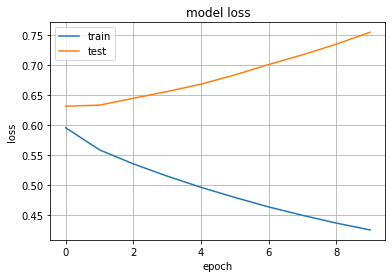

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
from keras.models import load_model
model2 = load_model('yolo.hdf5')

In [ ]:
scores = model2.evaluate(X_ts, y_ts, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 56.40%


In [ ]:
 model2.metrics_names

['loss', 'accuracy']

In [ ]:
y_pr_ts = model2.predict(X_ts)

In [ ]:
y_pred_tr = model2.predict(X_tr)

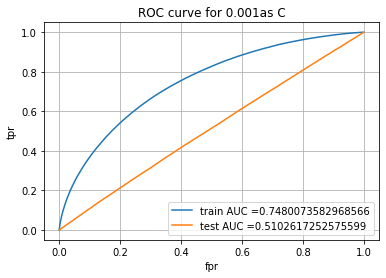

In [ ]:
from sklearn.metrics import roc_curve,auc,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score


train_fpr, train_tpr, tr_thresholds = roc_curve(y_tr, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_ts, y_pr_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (0.001)+'as C')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.2573567550077585 for threshold 0.33
train
the maximum value of tpr*(1-fpr) 0.4654546834638477 for threshold 0.346


train Confusion Matrix


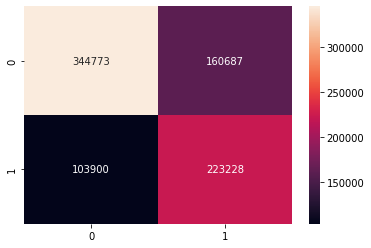

In [ ]:
print('train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_tr, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


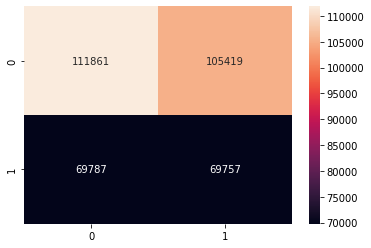

In [ ]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [ ]:
acc=accuracy_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
ps=precision_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
rc=recall_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
f1=f1_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 50.90%
Precision on test set: 39.82%
recall score on test set: 49.99%
f1 score on test set: 44.33%


## LSTM Based Model


In [ ]:
# create the model
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout,LSTM,Conv1D,MaxPooling1D,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed as Tdl
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
from clr import clr_callback
from tensorflow.python.keras.callbacks import TensorBoard
from time import time


batchSize = 128
column = max_sbe_length
channels = 1
embedding_vecor_length = 32



model4 = Sequential()
model4.add(Embedding(len(vocab)+1, embedding_vecor_length, input_length=max_sbe_length))
model4.add(LSTM(64,return_sequences=True))
model4.add(Dropout(0.3))
model4.add(LSTM(32,return_sequences=True))
model4.add(Flatten())
model4.add(Dropout(0.3))
model4.add(Dense(8,activation='relu'))
model4.add(Dense(1, activation='sigmoid'))

In [ ]:
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 128, 32)           377632    
_________________________________________________________________
lstm_8 (LSTM)                (None, 128, 64)           24832     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128, 32)           12416     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                

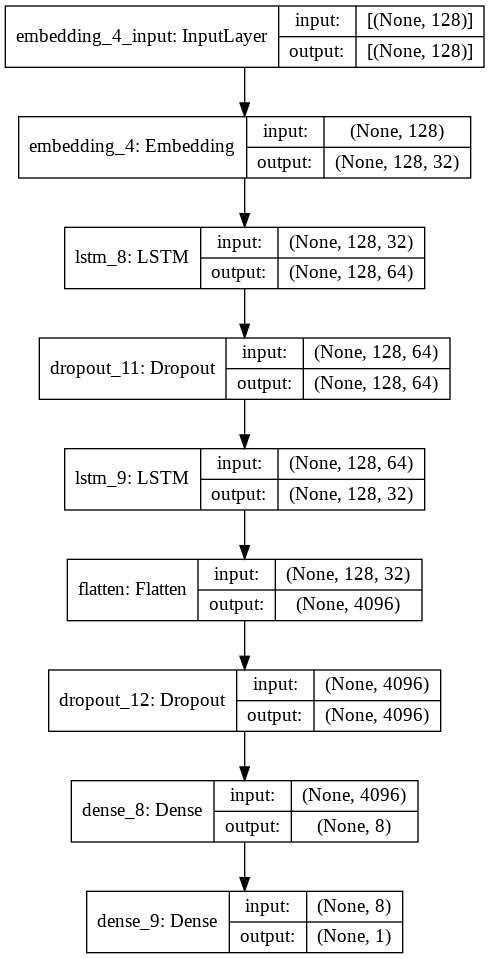

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model4, show_shapes=True, show_layer_names=True)

In [ ]:
filepath="tdl.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,save_best_only=True, mode='min')

callbacks_list = [checkpoint]
model4.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])


In [ ]:
history2 = model4.fit(X_tr, y_tr, validation_split = 0.3, epochs=10, verbose=1,batch_size=batchSize, callbacks = callbacks_list)

Epoch 1/10
4554/4554 [==============================] - 1319s 289ms/step - loss: 0.6072 - accuracy: 0.6697 - val_loss: 0.6362 - val_accuracy: 0.6471

Epoch 00001: val_loss improved from inf to 0.63616, saving model to tdl.hdf5
Epoch 2/10
4554/4554 [==============================] - 1313s 288ms/step - loss: 0.5750 - accuracy: 0.6963 - val_loss: 0.6367 - val_accuracy: 0.6511

Epoch 00002: val_loss did not improve from 0.63616
Epoch 3/10
4554/4554 [==============================] - 1334s 293ms/step - loss: 0.5538 - accuracy: 0.7130 - val_loss: 0.6411 - val_accuracy: 0.6505

Epoch 00003: val_loss did not improve from 0.63616
Epoch 4/10
4554/4554 [==============================] - 1329s 292ms/step - loss: 0.5364 - accuracy: 0.7257 - val_loss: 0.6531 - val_accuracy: 0.6560

Epoch 00004: val_loss did not improve from 0.63616
Epoch 5/10
4554/4554 [==============================] - 1326s 291ms/step - loss: 0.5202 - accuracy: 0.7375 - val_loss: 0.6495 - val_accuracy: 0.6562

Epoch 00005: val_los

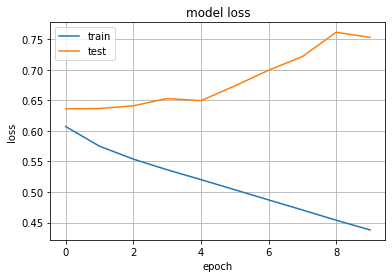

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
from keras.models import load_model
model2 = load_model('tdl.hdf5')

In [ ]:
scores = model2.evaluate(X_ts, y_ts, verbose=0)
print(scores)

[0.751381516456604, 0.5553241968154907]


In [ ]:
 model2.metrics_names

['loss', 'accuracy']

In [ ]:
y_pr_ts = model2.predict(X_ts)

In [ ]:
y_pred_tr = model2.predict(X_tr)

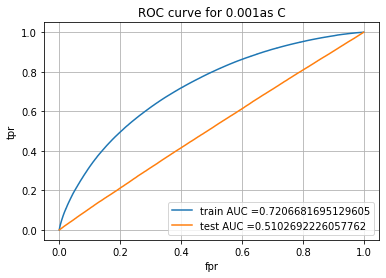

In [ ]:
from sklearn.metrics import roc_curve,auc,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score


train_fpr, train_tpr, tr_thresholds = roc_curve(y_tr, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_ts, y_pr_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (0.001)+'as C')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.2571559455473823 for threshold 0.362
train
the maximum value of tpr*(1-fpr) 0.4372178883491832 for threshold 0.378


train Confusion Matrix


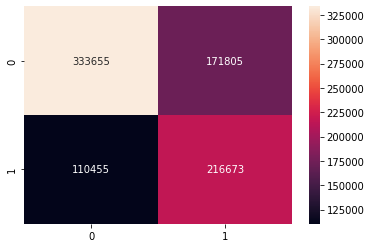

In [ ]:
print('train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_tr, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


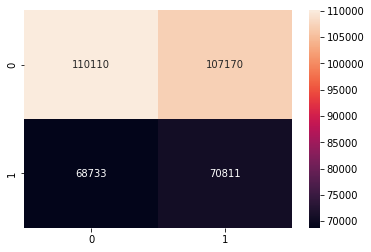

In [ ]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [ ]:
acc=accuracy_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
ps=precision_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
rc=recall_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
f1=f1_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 50.70%
Precision on test set: 39.79%
recall score on test set: 50.74%
f1 score on test set: 44.60%
